In [6]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the 'src' directory to the Python path
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
import metrics
from metrics import (
    sortino_ratio, calmar_ratio, cvar,
    sharpe_ratio, treynor_ratio, information_ratio
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# load cleaned returns (from data_expo work)
df = pd.read_csv("../data/220 obs 4 asset.csv", parse_dates=["Date"], dayfirst=True, index_col="Date")

returns = df  # since these are already log returns
benchmark = returns["Log_Return_SP500"]


In [7]:
# 2. Set parameters
n_assets = returns.shape[1]
n_portfolios = 5000  # number of random portfolios

# 3. Simulate random portfolios
results = []
for _ in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    port_ret = returns @ w
    
    results.append({
        "weights": w,
        "Sortino": sortino_ratio(port_ret),
        "Calmar": calmar_ratio(port_ret),
        "CVaR": cvar(port_ret),
        "Sharpe": sharpe_ratio(port_ret),
        "Treynor": treynor_ratio(port_ret, benchmark),
        "InfoRatio": information_ratio(port_ret, benchmark)
    })

results_df = pd.DataFrame(results)

# 4. Inspect first few results
print(results_df.head())


                                             weights   Sortino    Calmar  \
0  [0.18921666591546554, 0.3202613851617747, 0.07...  0.919090  0.497339   
1  [0.32219270800311994, 0.02731814416642689, 0.3...  0.694461  0.290890   
2  [0.26107476694060555, 0.013556506250778335, 0....  0.528222  0.167011   
3  [0.3063841547312356, 0.3571982689187219, 0.320...  1.011901  0.279448   
4  [0.2088719562970693, 0.3828817018246037, 0.171...  1.216515  0.504669   

       CVaR    Sharpe   Treynor  InfoRatio  
0 -0.042647  0.902552  0.727235  -0.102043  
1 -0.046074  0.709385  0.167148  -0.233086  
2 -0.066082  0.606353  0.096678  -0.350224  
3 -0.031924  1.059186  0.189595  -0.217202  
4 -0.029756  1.204881  0.375220  -0.123516  


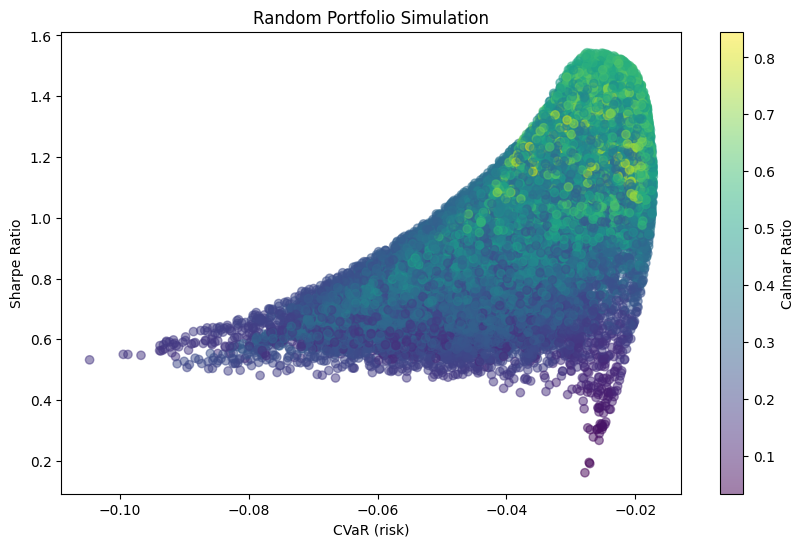


Top portfolios by Sharpe:
                                                 weights   Sortino    Calmar  \
26260  [0.005465596994523247, 0.7658052942643727, 0.1...  1.758186  0.547672   
1269   [0.057045735321594716, 0.7420166892743071, 0.1...  1.802513  0.561540   
45270  [0.02594451702290294, 0.7412111062331704, 0.13...  1.776677  0.552955   
6525   [0.06858255342075989, 0.7334603549502553, 0.11...  1.818698  0.557450   
9353   [0.002941195926396326, 0.7940365460889937, 0.1...  1.741446  0.562372   

           CVaR    Sharpe   Treynor  InfoRatio  
26260 -0.027476  1.543228  0.639529   0.012845  
1269  -0.025220  1.541827  0.761676  -0.016917  
45270 -0.026981  1.541661  0.617597   0.000421  
6525  -0.024956  1.540852  0.727218  -0.023537  
9353  -0.026518  1.540093  0.889433   0.014087  

Top portfolios by Sortino:
                                                 weights   Sortino    Calmar  \
25115  [0.1889451996198589, 0.804156050495619, 0.0026...  1.929421  0.511813   
4503   [0.

In [8]:
# 5. Visualize Sharpe vs CVaR, colored by Calmar
plt.figure(figsize=(10,6))
plt.scatter(results_df["CVaR"], results_df["Sharpe"], c=results_df["Calmar"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Calmar Ratio")
plt.xlabel("CVaR (risk)")
plt.ylabel("Sharpe Ratio")
plt.title("Random Portfolio Simulation")
plt.show()
# 6. Top portfolios by each metric
print("\nTop portfolios by Sharpe:")
print(results_df.sort_values("Sharpe", ascending=False).head())

print("\nTop portfolios by Sortino:")
print(results_df.sort_values("Sortino", ascending=False).head())

print("\nTop portfolios by Calmar:")
print(results_df.sort_values("Calmar", ascending=False).head())

Top equal-weight combined portfolio score (equal):
weights: [0.00364135 0.79566518 0.05946929 0.14122418]
Sortino        0.905389
Calmar         0.701867
CVaR          -0.027309
Sharpe         0.971992
Treynor        0.649566
InfoRatio      0.987062
score_equal    0.721884
Name: 1555, dtype: object
Top 10 most-frequently selected portfolios across random metric-weightings:
[(15844, 48), (1555, 35), (37380, 27), (26260, 17), (49770, 16), (35924, 12), (212, 9), (14658, 7), (16124, 5), (34251, 5)]
Saved top candidates to reports/top_candidate_portfolios.csv


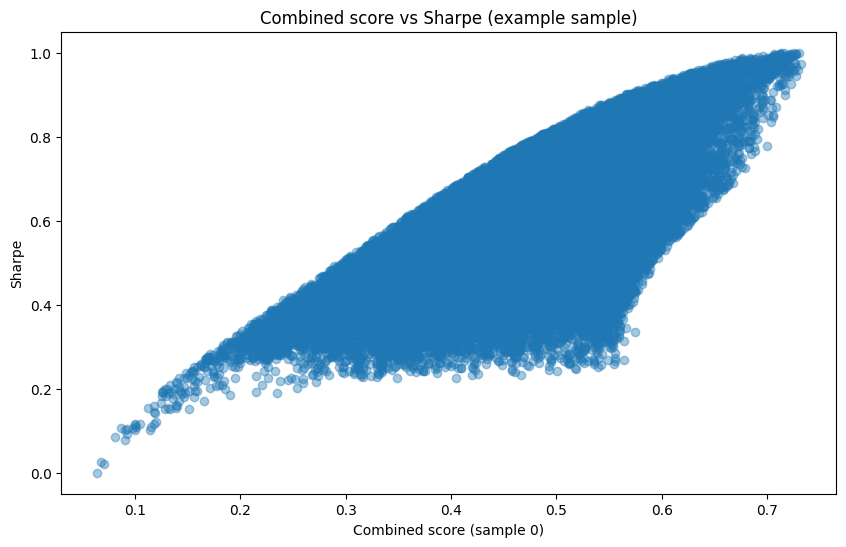

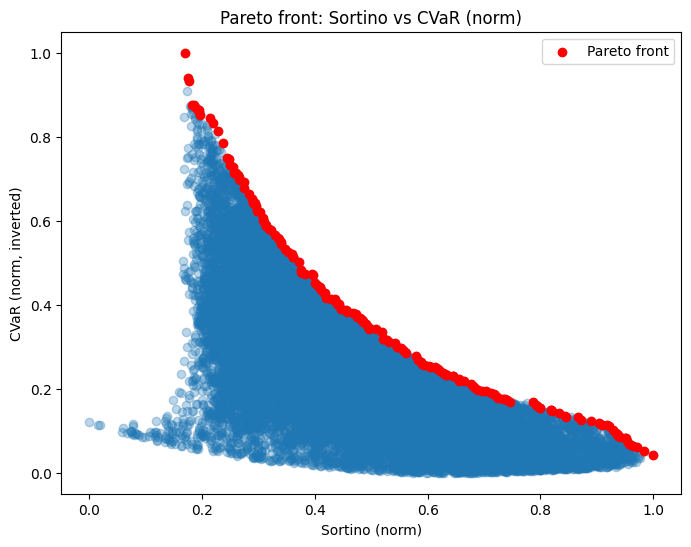

In [ ]:

from sklearn.preprocessing import MinMaxScaler

# 1) Choose metric columns to include 
metric_cols = ["Sortino", "Calmar", "CVaR", "Sharpe", "Treynor", "InfoRatio"]

# 2) Prepare a copy and handle NaNs: drop portfolios with NaN metrics (or fill)
dfm = results_df.copy().reset_index(drop=True)
dfm = dfm.dropna(subset=metric_cols).reset_index(drop=True)

# For CVaR (a loss metric), we want higher-is-better: invert it
dfm["CVaR_pos"] = -dfm["CVaR"]   # so larger = better

# 3) Normalise metrics to [0,1] using MinMax (per metric)
norm_cols = ["Sortino", "Calmar", "CVaR_pos", "Sharpe", "Treynor", "InfoRatio"]
scaler = MinMaxScaler()
dfm_norm = dfm.copy()
dfm_norm[norm_cols] = scaler.fit_transform(dfm[norm_cols])

# sanity check
dfm_norm[[*norm_cols]].describe().T

# 4) function to compute combined score given a dict of weights
def compute_combined_score(df_norm, weights_dict):
    """
    df_norm : dataframe with normalized columns named as in norm_cols
    weights_dict : dict {metric_name: weight}, metric_name must match norm_cols mapping
                   e.g. {"Sortino":0.25, "Calmar":0.25, "CVaR":0.25, "Sharpe":0.25}
                   note: for CVaR use key "CVaR" but it will map to "CVaR_pos" internally
    """
    # map user metric keys to normalized column names
    col_map = {
        "Sortino": "Sortino",
        "Calmar": "Calmar",
        "CVaR": "CVaR_pos",
        "Sharpe": "Sharpe",
        "Treynor": "Treynor",
        "InfoRatio": "InfoRatio"
    }
    # build score
    score = np.zeros(len(df_norm))
    total_w = 0.0
    for k, w in weights_dict.items():
        if k not in col_map:
            raise ValueError(f"Unknown metric: {k}")
        score += w * df_norm[col_map[k]].values
        total_w += w
    if total_w == 0:
        raise ValueError("Sum of weights must be > 0")
    # normalise by sum of weights so weights don't need to sum to 1
    score = score / total_w
    return score

# Example: equal weights
equal_w = {"Sortino":1, "Calmar":1, "CVaR":1, "Sharpe":1, "Treynor":1, "InfoRatio":1}
dfm_norm["score_equal"] = compute_combined_score(dfm_norm, equal_w)

# Pick top candidate under equal weights
top_equal = dfm_norm.loc[dfm_norm["score_equal"].idxmax()]
print("Top equal-weight combined portfolio score (equal):")
print("weights:", top_equal["weights"])
print(top_equal[["Sortino","Calmar","CVaR","Sharpe","Treynor","InfoRatio","score_equal"]])

# 5) Explore many weight combinations (random sampling of metric-weights)
def sample_weight_vectors(n_samples=100, metrics_list=None, seed=42):
    rng = np.random.default_rng(seed)
    m = len(metrics_list)
    ws = rng.random((n_samples, m))
    ws = ws / ws.sum(axis=1, keepdims=True)
    weight_dicts = []
    for i in range(n_samples):
        weight_dicts.append({metrics_list[j]: float(ws[i,j]) for j in range(m)})
    return weight_dicts

# sample 200 random weightings
metric_keys = ["Sortino", "Calmar", "CVaR", "Sharpe", "Treynor", "InfoRatio"]
weight_samples = sample_weight_vectors(n_samples=200, metrics_list=metric_keys)

# Apply each weighting and record best portfolio index
top_indices = []
scores_matrix = []
for i, wdict in enumerate(weight_samples):
    sc = compute_combined_score(dfm_norm, wdict)
    scores_matrix.append(sc)
    top_idx = int(np.nanargmax(sc))
    top_indices.append(top_idx)

# Count how often each portfolio appears as top
from collections import Counter
top_counter = Counter(top_indices)
most_common = top_counter.most_common(10)
print("Top 10 most-frequently selected portfolios across random metric-weightings:")
print(most_common)

# 6) Save the top unique candidates (those occurring frequently)
freq_threshold = 3  # appear at least this many times among 200 samples
candidates = [idx for idx, cnt in top_counter.items() if cnt >= freq_threshold]
candidates_df = dfm_norm.loc[candidates].copy()
candidates_df["freq"] = [top_counter[idx] for idx in candidates]
candidates_df = candidates_df.sort_values("freq", ascending=False)
candidates_df.to_csv("../reports/top_candidate_portfolios.csv", index=False)
print("Saved top candidates to reports/top_candidate_portfolios.csv")

# 7) Visualise combined-score surface for a selected weight sample (example)
sample_w = weight_samples[0]  # pick first sample
dfm_norm["sample_score_0"] = compute_combined_score(dfm_norm, sample_w)

plt.figure(figsize=(10,6))
plt.scatter(dfm_norm["sample_score_0"], dfm_norm["Sharpe"], alpha=0.4)
plt.xlabel("Combined score (sample 0)")
plt.ylabel("Sharpe")
plt.title("Combined score vs Sharpe (example sample)")
plt.show()

# 8) Pareto front (2-metric view example: Sortino vs CVaR_pos)
# A function to compute Pareto (maximisation for both metrics)
def pareto_front(df, xcol, ycol):
    data = df[[xcol, ycol]].copy().values
    # sort by x descending then compute cumulative max of y
    order = np.argsort(-data[:,0])
    pareto_idx = []
    best_y = -np.inf
    for idx in order:
        y = data[idx,1]
        if y > best_y:
            pareto_idx.append(idx)
            best_y = y
    return pareto_idx

pf_idx = pareto_front(dfm_norm, "Sortino", "CVaR_pos")
plt.figure(figsize=(8,6))
plt.scatter(dfm_norm["Sortino"], dfm_norm["CVaR_pos"], alpha=0.3)
plt.scatter(dfm_norm.iloc[pf_idx]["Sortino"], dfm_norm.iloc[pf_idx]["CVaR_pos"], color="red", label="Pareto front")
plt.xlabel("Sortino (norm)")
plt.ylabel("CVaR (norm, inverted)")
plt.legend()
plt.title("Pareto front: Sortino vs CVaR (norm)")
plt.show()


In [10]:
#optimisation!!!

def neg_sharpe_ratio(weights, returns_df, risk_free_rate=0):
    """
    Calculates the negative Sharpe ratio for a given set of portfolio weights.
    The function to be minimized by the optimizer.
    """
    portfolio_return = np.sum(returns_df.mean() * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns_df.cov() * 252, weights)))
    
    sharpe = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    # We return the negative Sharpe ratio because optimizers minimize.
    return -sharpe

In [ ]:
import itertools

# Step 1: Define the grid parameters
n_assets = returns.shape[1]
weight_step = 0.05 # Check weights in 5% increments


weights_list = []
for w in itertools.product(np.arange(0, 1 + weight_step, weight_step), repeat=n_assets):
    if np.isclose(sum(w), 1.0): # Ensure weights sum to 1
        weights_list.append(w)

print(f"Generated {len(weights_list)} weight combinations for grid search.")

# Step 3: Calculate Sharpe for each combination
grid_results = []
for weights in weights_list:
    sharpe = -neg_sharpe_ratio(np.array(weights), returns) # Use the function from before
    grid_results.append({'weights': weights, 'Sharpe': sharpe})

# Step 4: Find the best result
grid_results_df = pd.DataFrame(grid_results)
best_portfolio_grid = grid_results_df.loc[grid_results_df['Sharpe'].idxmax()]

print("\nBest Portfolio (Grid Search):")
print(best_portfolio_grid)

Generated 1771 weight combinations for grid search.

Best Portfolio (Grid Search):
weights    (0.0, 0.8, 0.1, 0.1)
Sharpe                  7.05602
Name: 218, dtype: object


In [13]:
from scipy.optimize import differential_evolution, LinearConstraint

# Step 1: Define bounds and constraints
n_assets = returns.shape[1]
# Bounds: Each weight must be between 0 and 1
bounds = tuple((0, 1) for asset in range(n_assets))

# Constraints: The sum of weights must be 1. 
# This is a linear constraint: 1*w1 + 1*w2 + ... = 1
# We create a LinearConstraint object for this.
constraints = LinearConstraint(np.ones(n_assets), lb=1, ub=1)

# Step 2: Run the optimizer
# We are minimizing our neg_sharpe_ratio function
result_de = differential_evolution(
    neg_sharpe_ratio, 
    bounds=bounds, 
    args=(returns,), 
    constraints=constraints,
    seed=42
)

# Step 3: Display the results
best_weights_de = result_de.x
best_sharpe_de = -result_de.fun # Invert the result back to positive

print("Best Portfolio (Differential Evolution):")
print("Weights:", best_weights_de)
print("Sharpe Ratio:", best_sharpe_de)

Best Portfolio (Differential Evolution):
Weights: [1.93892974e-06 7.80752956e-01 1.25577342e-01 9.36677636e-02]
Sharpe Ratio: 7.077733176935566


In [14]:
from scipy.optimize import minimize

# Step 1: Set up bounds, constraints, and an initial guess
# Bounds and constraints are the same as for the heuristic method
bounds = tuple((0, 1) for asset in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Initial guess (equal weights)
initial_weights = np.array(n_assets * [1. / n_assets,])

# Step 2: Run the optimizer
# Method 'SLSQP' is a good choice for constrained optimization problems
result_slsqp = minimize(
    neg_sharpe_ratio, 
    initial_weights, 
    args=(returns,),
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

# Step 3: Display the results
best_weights_slsqp = result_slsqp.x
best_sharpe_slsqp = -result_slsqp.fun # Invert back to positive

print("Best Portfolio (Gradient-Based - SLSQP):")
print("Weights:", best_weights_slsqp)
print("Sharpe Ratio:", best_sharpe_slsqp)

Best Portfolio (Gradient-Based - SLSQP):
Weights: [7.10455335e-18 7.80832450e-01 1.25584408e-01 9.35831423e-02]
Sharpe Ratio: 7.077732974505316


Generated portfolio_optimization_comparison.png


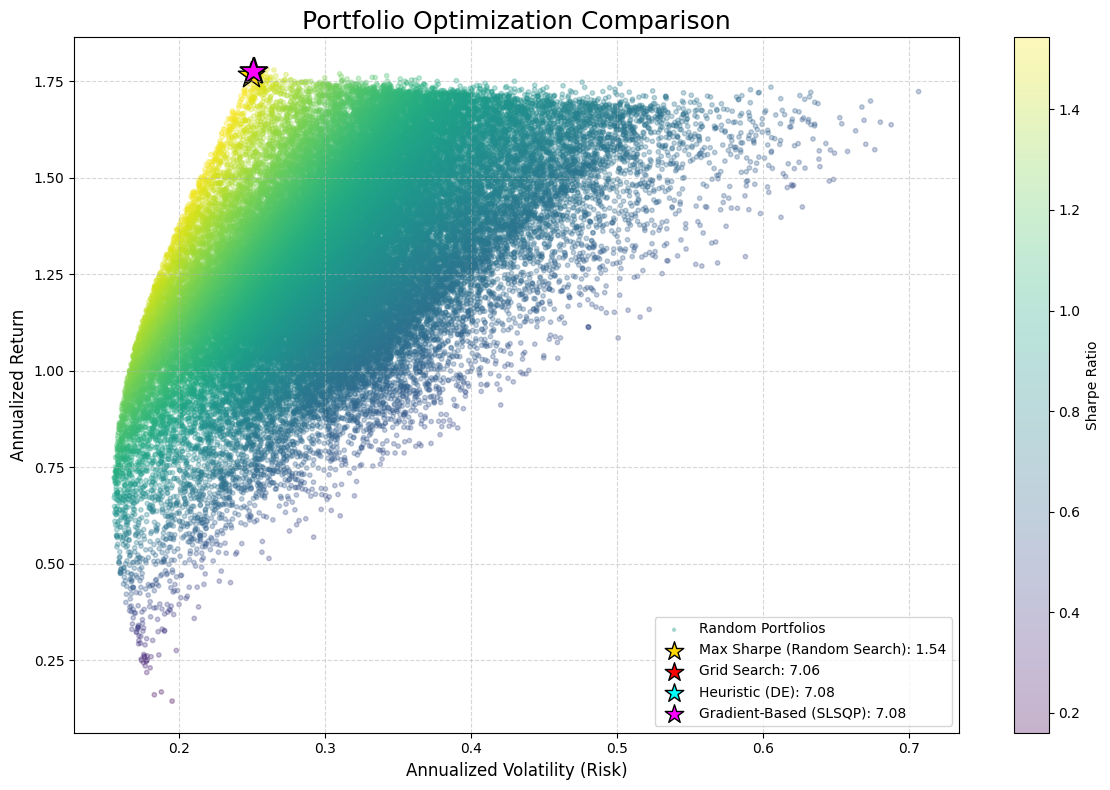

In [15]:

# Assuming 'returns' is your DataFrame of asset log returns
# And 'results_df' is your DataFrame from the 5000 random simulations

portfolio_returns = []
portfolio_volatility = []
portfolio_weights = results_df['weights'].tolist()

for w in portfolio_weights:
    w = np.array(w)
    ret = np.sum(returns.mean() * w) * 252
    vol = np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w)))
    portfolio_returns.append(ret)
    portfolio_volatility.append(vol)

results_df['Return'] = portfolio_returns
results_df['Volatility'] = portfolio_volatility

# --- Step 2: Identify the key portfolios to highlight ---
# Find the portfolio with the max Sharpe ratio from the initial random search
max_sharpe_random = results_df.loc[results_df['Sharpe'].idxmax()]

# Let's create a dictionary to hold the results of your targeted optimizations
# Assuming the 'best_...' variables from the previous step exist
optimized_portfolios = {
    "Grid Search": best_portfolio_grid,
    "Heuristic (DE)": pd.Series({'weights': best_weights_de, 'Sharpe': best_sharpe_de}),
    "Gradient-Based (SLSQP)": pd.Series({'weights': best_weights_slsqp, 'Sharpe': best_sharpe_slsqp})
}

# Calculate Return and Volatility for each optimized portfolio
optimized_results = {}
for name, port in optimized_portfolios.items():
    w = np.array(port['weights'])
    ret = np.sum(returns.mean() * w) * 252
    vol = np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w)))
    optimized_results[name] = {'Return': ret, 'Volatility': vol, 'Sharpe': port['Sharpe']}

# --- Step 3: Create the plot ---
plt.figure(figsize=(12, 8))

# Plot all the random portfolios, colored by Sharpe ratio
plt.scatter(
    results_df['Volatility'], 
    results_df['Return'], 
    c=results_df['Sharpe'], 
    cmap='viridis', 
    marker='o', 
    s=10, 
    alpha=0.3, 
    label='Random Portfolios'
)
cbar = plt.colorbar(label='Sharpe Ratio')

# Plot the best portfolio from the random search
plt.scatter(
    max_sharpe_random['Volatility'], 
    max_sharpe_random['Return'], 
    marker='*', 
    color='gold', 
    s=400, 
    edgecolors='black',
    label=f"Max Sharpe (Random Search): {max_sharpe_random['Sharpe']:.2f}"
)

# Plot the portfolios from the targeted optimization methods
colors = ['red', 'cyan', 'magenta']
for i, (name, res) in enumerate(optimized_results.items()):
    plt.scatter(
        res['Volatility'], 
        res['Return'], 
        marker='*', 
        color=colors[i], 
        s=400, 
        edgecolors='black',
        label=f"{name}: {res['Sharpe']:.2f}"
    )

plt.title('Portfolio Optimization Comparison', fontsize=18)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='best', fontsize=10, markerscale=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("portfolio_optimization_comparison.png")
print("Generated portfolio_optimization_comparison.png")